In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from json import load as json_load
import gudhi
import gudhi.wasserstein
import gudhi.hera
import seaborn as sns
import pickle

2025-08-20 16:44:59.139783: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Look at the dataset

In [12]:
np.random.seed(2024)
X0 = np.random.normal(scale=0.10, size=(100, 2))   # class 0
y0 = [0] * 100

X1 = make_circles(
    n_samples=200, noise=0.05, factor=0.5,
    shuffle=False, random_state=2024
)[0][100:]
y1 = [1] * 100

X = np.vstack([X0, X1]).astype(np.float32)
y = y0+y1

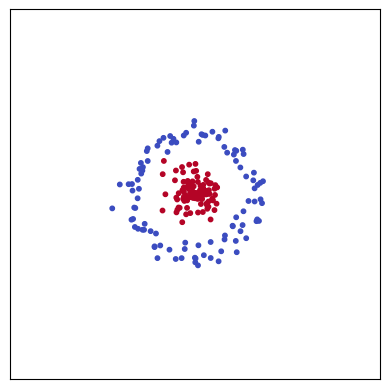

In [13]:
plt.scatter(X[:, 0], X[:, 1], c=1-np.array(y), cmap='coolwarm', s=10)  
plt.gca().set_aspect('equal', adjustable='box')  
plt.xticks([])
plt.yticks([])
plt.ylim(-1.5, 1.5)
plt.xlim(-1.5, 1.5)
plt.savefig('nn_dataset.png', bbox_inches='tight', dpi=150)

In [14]:
from sklearn.metrics import euclidean_distances
from scipy.optimize import linear_sum_assignment

def weightedW(P, Q):
    if len(P) == 0 and len(Q) == 0:
        return 0
    PP = [x for x in P]
    QQ = [x for x in Q]
    PP.extend([[(x[0]+x[1])/2, (x[0]+x[1])/2] for x in Q])
    QQ.extend([[(x[0]+x[1])/2, (x[0]+x[1])/2] for x in P])
    PP = np.array(PP)
    QQ = np.array(QQ)
    M1 = np.abs(PP[:,0][:, None] - QQ[:,0][None, :])
    M2 = np.abs(PP[:,1][:, None] - QQ[:,1][None, :])
    M = np.max([M1, M2], axis=0)
    M[len(P):,:][:,len(Q):] = 0
    W = ( (PP@np.array([-1,1]))[:, None] + (QQ@np.array([-1,1]))[None, :])/(2*np.sqrt(2))
    row_ind, col_ind = linear_sum_assignment(M*W)
    return (M*W)[row_ind, col_ind].sum()

def vineyardDistance(PDs):
    ds = [weightedW(PDs[i], PDs[i+1]) for i in range(len(PDs)-1)]
    return sum(ds)


In [15]:
def plot_PD_frame(margin = 1):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(0,margin)
    ax.set_xticks(np.arange(0, margin, 0.2))
    ax.set_yticks(np.arange(0, margin, 0.2))
    ax.set_ylim(0,margin)
    ax.set_aspect(1)
    ax.plot([0,margin], [0,margin], linestyle='dashed', c='grey')
    return ax

## Experiments varying depth and batch size

In [ ]:
vds = []
files = []
trials = []
broken_down_vds = []

bs = [8, 16, 32, 64]
for b in bs:
    broken_down_vds.append([])
    data = json_load(open(f'vineyard_results/bs_{b}.json'))
    for trial in range(len(data['trials'])):
        PDs = data['trials'][trial]['H1']
        vd = vineyardDistance(PDs)
        vds.append(vd)
        final_acc = data['trials'][trial]['metrics'][-1]['train_acc']
        if final_acc > 0.95:
            broken_down_vds[-1].append(vd)
        files.append(f'bs_{b}.json')
        trials.append(trial)

depths = [1,3,5,7]
for d in depths:
    broken_down_vds.append([])
    data = json_load(open(f'vineyard_results/depth_{d}.json'))
    for trial in range(len(data['trials'])):
        PDs = data['trials'][trial]['H1']
        vd = vineyardDistance(PDs)
        vds.append(vd)
        final_acc = data['trials'][trial]['metrics'][-1]['train_acc']
        if final_acc > 0.95:
            broken_down_vds[-1].append(vd)
        files.append(f'depth_{d}.json')
        trials.append(trial)

#lr 
lr = ['5e-03', '1e-02', '5e-02', '1e-01']
for l in lr:
    broken_down_vds.append([])
    data = json_load(open(f'vineyard_results/lr_{l}.json'))
    for trial in range(len(data['trials'])):
        PDs = data['trials'][trial]['H1']
        vd = vineyardDistance(PDs)
        vds.append(vd)
        final_acc = data['trials'][trial]['metrics'][-1]['train_acc']
        if final_acc > 0.95:
            broken_down_vds[-1].append(vd)
        files.append(f'lr_{l}.json')
        trials.append(trial)

pickle.dump((vds, files, trials, broken_down_vds), open('vineyard_data.pkl', 'wb'))


In [16]:
vds, files, trials, broken_down_vds = pickle.load(open('vineyard_data.pkl', 'rb'))

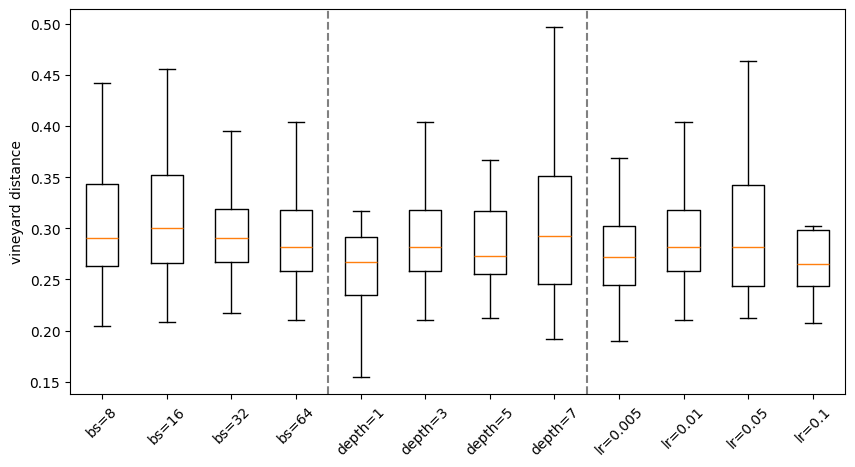

In [21]:
plt.subplots(figsize=(10, 5))
plt.boxplot(broken_down_vds, showfliers=False)
plt.gca().axvline(4.5, linestyle='--', color='gray')
plt.gca().axvline(8.5, linestyle='--', color='gray')
plt.xticks(range(1,len(broken_down_vds)+1), ['bs=8', 'bs=16', 'bs=32', 'bs=64', 'depth=1', 'depth=3', 'depth=5', 'depth=7', 'lr=0.005', 'lr=0.01', 'lr=0.05', 'lr=0.1'], rotation=45)
plt.ylabel('vineyard distance')
plt.savefig('experiment_boxplots.png', bbox_inches='tight', dpi=150)
plt.show()

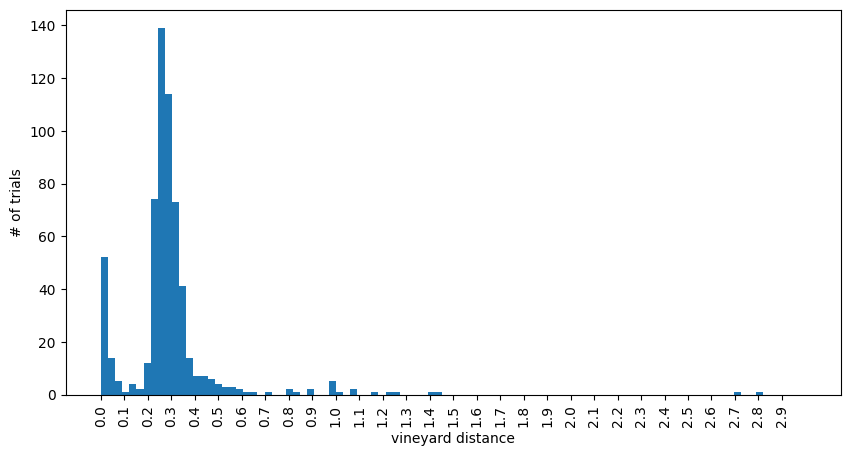

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.xticks([0.1*x for x in range(30)], rotation=90)
plt.hist(vds, bins=np.linspace(0,3,100))
plt.xlabel('vineyard distance')
plt.ylabel('# of trials')
plt.savefig('experiment_histogram.png', bbox_inches='tight', dpi=150)
plt.show()

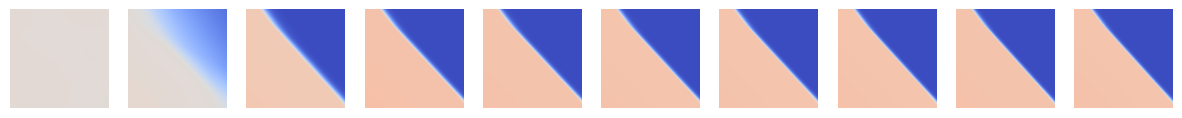

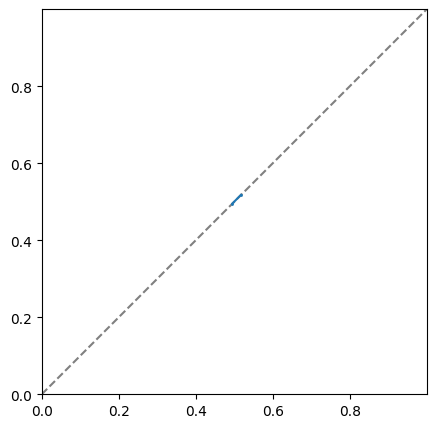

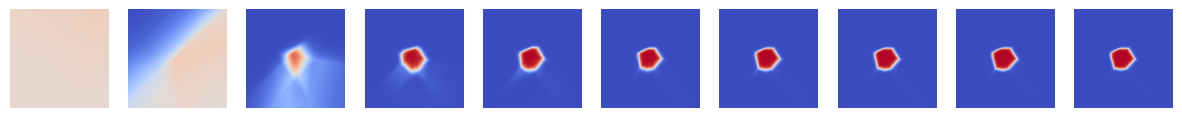

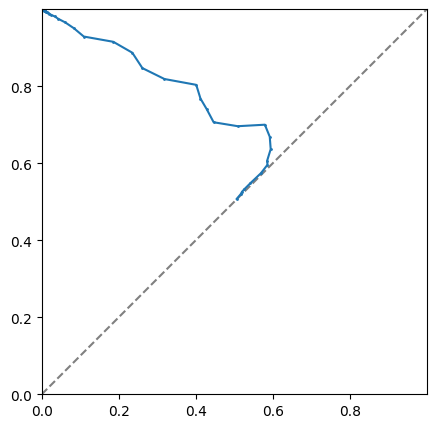

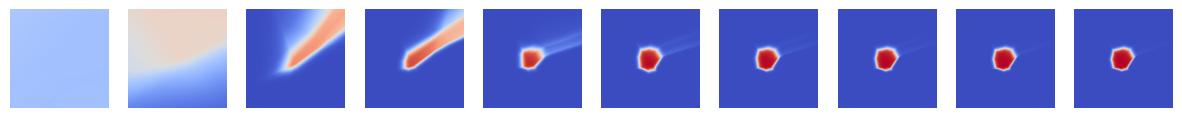

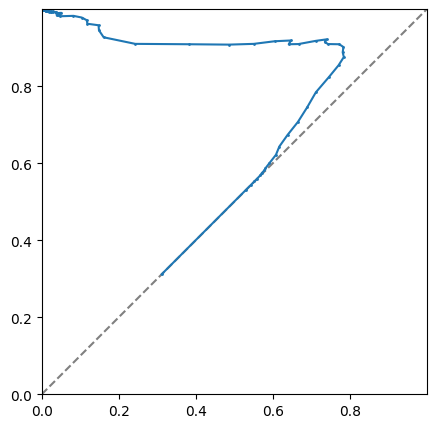

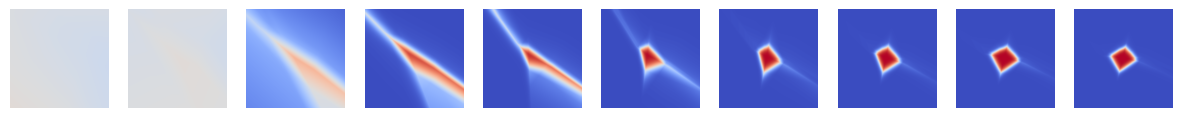

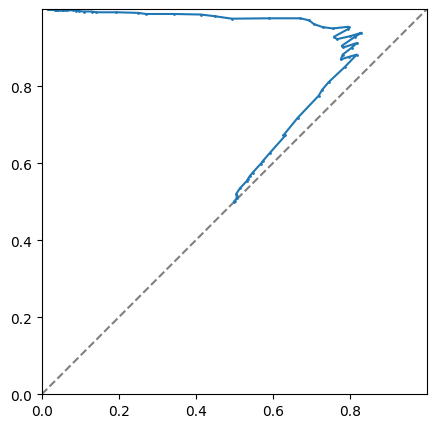

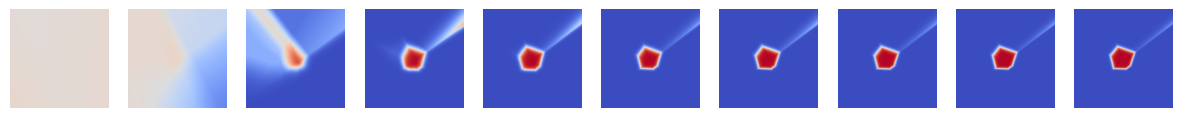

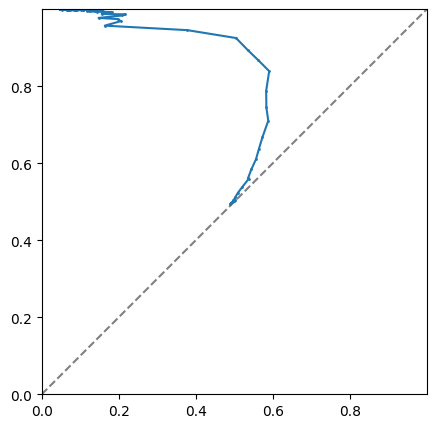

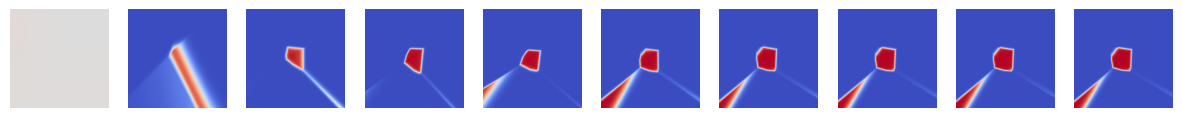

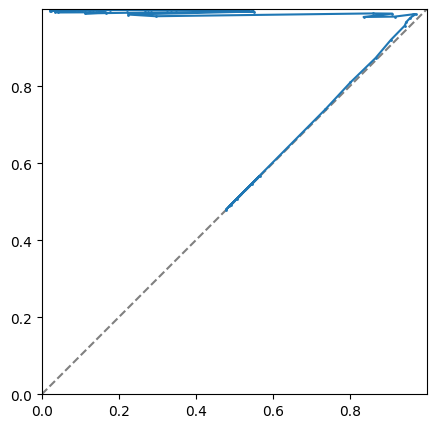

In [32]:

lookpoints = [0.0, 0.25, 0.35, 0.6, 1.0, 2.7]
example_vds = []
train_accs = []

for idx, lookpoint in enumerate(lookpoints):
    if idx == len(lookpoints) - 1:
        closest_vd_idx = np.argsort(np.abs(np.array(vds) - lookpoint))[0]
    else:
        closest_vd_idx = 250+np.argsort(np.abs(np.array(vds[250:300]) - lookpoint))[0]
    file = files[closest_vd_idx]
    trial = trials[closest_vd_idx]
    data = json_load(open(f'vineyard_results/{file}'))
    result = np.load('vineyard_results/{}/trial_{}_grids.npz'.format(file.rstrip('.json'), trial))
    PDs = data['trials'][trial]['H1']
    train_acc = data['trials'][trial]['metrics'][-1]['train_acc']
    train_accs.append(train_acc)

    plots = 10
    fig, ax = plt.subplots(1, plots, figsize=(15, 5))
    for j, i in enumerate([i*(100//(plots-1)) for i in range(plots)]):
        img = result['grids'][i]
        ax[j].imshow(img, cmap='coolwarm', vmin=0, vmax=1)
        ax[j].axis('off')
    plt.savefig(f'example_traj{idx}.png', bbox_inches='tight', dpi=150)
    plt.show()
    result.close()
    example_vds.append(vds[closest_vd_idx])
    
    ax = plot_PD_frame()
    xs = []
    ys = []
    for PD in PDs:
        if len(PD) == 0:
            continue
        PD_point = sorted(PD, key=lambda x: x[0]-x[1])[0]
        xs.append(PD_point[0])
        ys.append(PD_point[1])
    plt.plot(xs, ys, marker='o', linestyle='-', markersize=1)
    plt.savefig(f'vineyard_trial{idx}.png', bbox_inches='tight', dpi=150)
    plt.show()

In [31]:
example_vds

[1.685873940435761e-07,
 0.25006594214494016,
 0.3509571565890936,
 0.43947644441273725,
 0.9697520150303649,
 2.716431900855927]

In [33]:
train_accs

[0.69375, 1.0, 1.0, 0.99375, 1.0, 1.0]